## FaceRecognition 26/05/2020

In this notebook, we will train the faceNet convolutional neural network on the created dataset using Augmentor to augment images on the fly using a generator.

In [89]:
import keras
from keras.models import Sequential,load_model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D

import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

In [131]:
## define the model of the ConvNet

num_classes = 10
input_shape = (256, 256, 3)

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

Once a network has been defined, compile it so that the model is ready to be trained with data:

In [132]:
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

View a summary of the network using the `summary()` function:

In [133]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 254, 254, 32)      896       
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 252, 252, 64)      18496     
_________________________________________________________________
max_pooling2d_82 (MaxPooling (None, 126, 126, 64)      0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 126, 126, 64)      0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 1016064)           0         
_________________________________________________________________
dense_7 (Dense)              (None, 128)               130056320 
_________________________________________________________________
dropout_8 (Dropout)          (None, 128)              

In [134]:
from keras.preprocessing.image import ImageDataGenerator

batch_size = 10
train_datagen = ImageDataGenerator(
      rotation_range=20,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      vertical_flip=True,
      fill_mode='nearest')

g = train_datagen.flow_from_directory(
        './images/train',
        target_size=(256, 256),
        batch_size=batch_size,
        class_mode='categorical')

images,labels=next(g)


Found 286 images belonging to 10 classes.


In [135]:
h = model.fit(g, steps_per_epoch=len(p.augmentor_images)/batch_size, epochs=200, verbose=1)

Epoch 1/2
10/9 [================================] - 50s 5s/step - loss: 5285.8957 - accuracy: 0.1000
Epoch 2/2
10/9 [================================] - 37s 4s/step - loss: 13.3475 - accuracy: 0.0938


In [136]:
import os

test_dirpath = os.path.join('./image/test/')
test_filepaths = [os.path.join(test_dirpath, f) for f in os.listdir(test_dirpath)]

In [137]:
cascade_path = './model/cv2/haarcascade_frontalface_default.xml'   # contains the path to the cv2 model file 
cascade = cv2.CascadeClassifier(cascade_path)

In [138]:
from PIL import Image
import numpy as np
from skimage import transform

def load(filename):
    np_image = Image.open(filename)
    np_image = np.array(np_image).astype('float32')/255
    np_image = transform.resize(np_image, (256, 256, 3))
    np_image = np.expand_dims(np_image, axis=0)
    return np_image


classes=[]

for i in range(len(test_filepaths)):
    img=load(test_filepaths[i])
    y_prob = model.predict(img) 
    y_classes = y_prob.argmax(axis=-1)
    classes.append(y_classes)

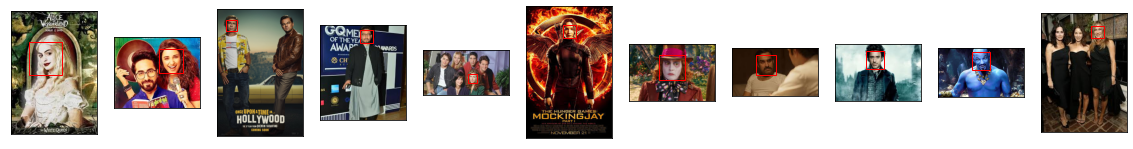

In [139]:
import matplotlib.patches as patches
from imageio import imread
import cv2

fig, axes = plt.subplots(1, len(test_filepaths), figsize=(20, 5))

margin=10
aligned_images = []        
        
for i in range(len(test_filepaths)):
    #axes[i].set_title(str(classes[i]))
    axes[i].imshow(imread(test_filepaths[i]))
    axes[i].set_xticks([])
    axes[i].set_yticks([])
    img = imread(test_filepaths[i])
    
    #faces = cascade.detectMultiScale(img,1.3,2)
    faces = cascade.detectMultiScale(img,scaleFactor=1.1,minNeighbors=5,minSize=(10, 10),flags=cv2.CASCADE_SCALE_IMAGE)
    (x, y, w, h) = faces[0]
    cropped = img[y-margin//2:y+h-margin//2,
                    x-margin//2:x+w-margin//2, :]
    
    (w,h,z)=cropped.shape
    # create a box around the detected face
    rect = patches.Rectangle((x,y),w,h,linewidth=1,edgecolor='r',facecolor='none')
    # Add the patch to the Axes
    axes[i].add_patch(rect)
    
    
plt.show()